In [ ]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [ ]:
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import folium
import os

import torch
from torchvision import datasets, models, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ee.Authenticate()
ee.Initialize(project="lulc-project-v288399work")

In [ ]:
# ISO and ADM codes for India
ISO = 'IND'  # "IND" is the ISO code for India
ADM = 'ADM2'  # Equivalent to administrative districts in India

# Query geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Save the result as a GeoJSON
filename = 'india_geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (735, 6)


shapeName shapeISO                  shapeID shapeGroup  \
389                  Barddhaman           76128533B59121537940607        IND   
387  North Twenty Four Parganas           76128533B93453964263910        IND   
500                     Cuttack           76128533B70842759816811        IND   

    shapeType                                           geometry  
389      ADM2  POLYGON ((88.19703 23.76513, 88.19355 23.76403...  
387      ADM2  POLYGON ((88.41098 22.94568, 88.41241 22.94026...  
500      ADM2  POLYGON ((86.18911 20.05408, 86.18041 20.06348...

In [ ]:
print(geoboundary.columns)

Index(['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType',
       'geometry'],
      dtype='object')


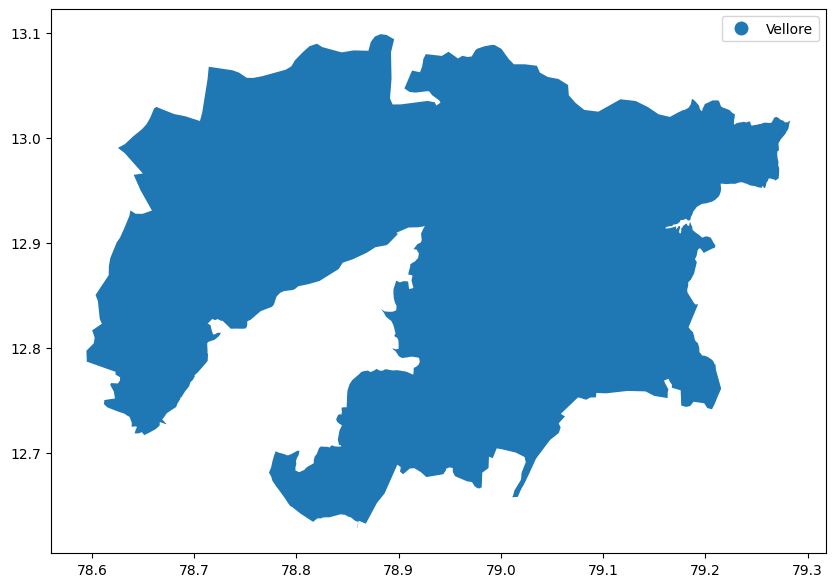

In [ ]:
shape_name = 'Vellore'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);




In [ ]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):


    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)

    return image.clip(region)

In [ ]:
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region)
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2021-01-01', # Get all images within
    max_date='2021-12-31', # the year 2021
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = geemap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

Map(center=[12.8920834450469, 78.92685441826417], controls=(WidgetControl(options=['position', 'transparent_bg…

In [ ]:
def export_image(image, filename, region, folder):
    """Exports the generated image to Google Drive as a GeoTIFF file."""

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=30,  # Landsat 8 has a 30m resolution for RGB bands
      region=region.geometry(),  # Ensure the region is properly passed as a geometry
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',  # CRS in WGS84 format
      maxPixels=1e13  # Handle large images with more pixels
    )

    task.start()

    return task




In [ ]:
folder = 'lulc-test-folder' # Change this to your file destination folder in Google drive


task = export_image(image, shape_name, region, folder)

Exporting to Vellore.tif ...


In [ ]:
task.status()

{'state': 'COMPLETED',
 'description': 'Vellore',
 'priority': 100,
 'creation_timestamp_ms': 1730710426644,
 'update_timestamp_ms': 1730710561437,
 'start_timestamp_ms': 1730710432335,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1qZxj2iSd_10o0N9Woj4mlOpjfUnweKCo'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 212.2282257080078,
 'id': 'LOYI433RIPRXUAJM4MNW3477',
 'name': 'projects/lulc-project-v288399work/operations/LOYI433RIPRXUAJM4MNW3477'}

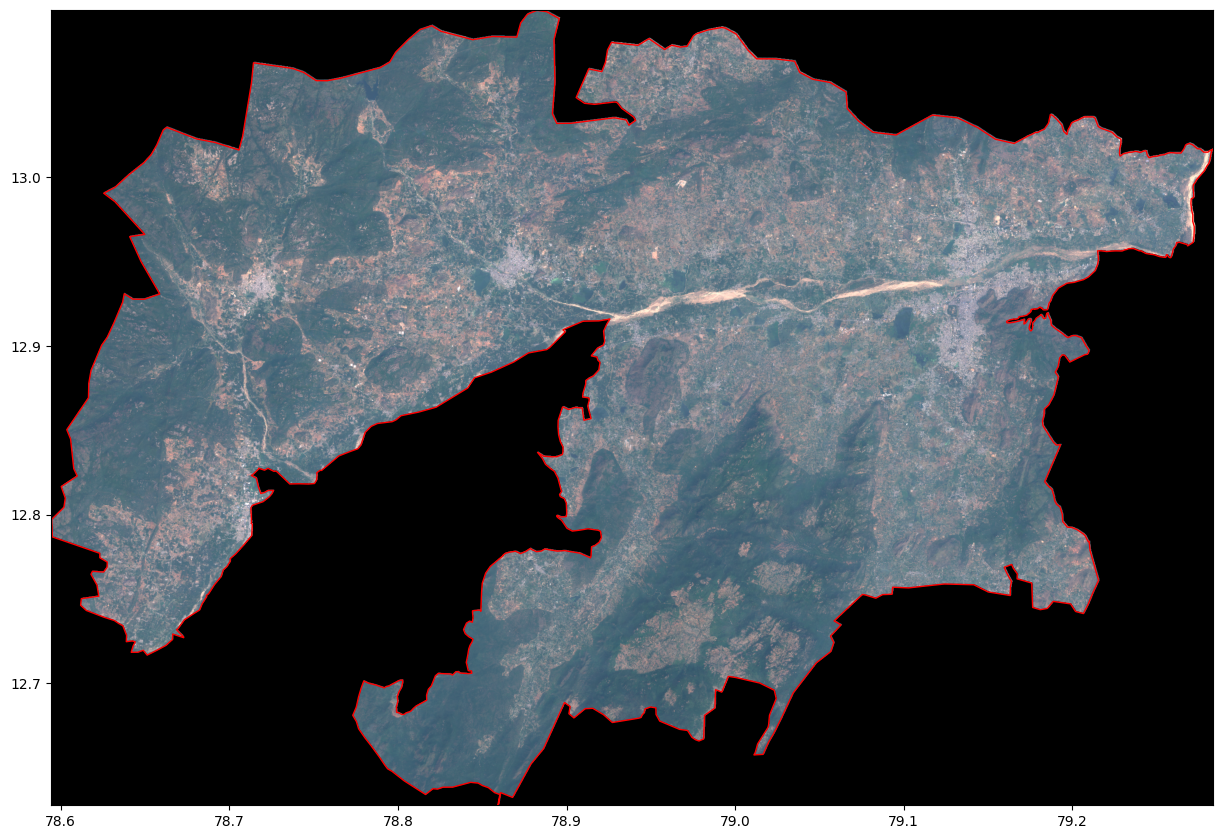

In [ ]:
# Change this to your image file path
cwd = './drive/My Drive/lulc-project/'
tif_file = cwd + '{}.tif'.format(shape_name)

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

In [ ]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

In [ ]:
output_file = os.path.join(cwd, '{}.geojson'.format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

# Uncomment this to download GeoJSON file
#if not os.path.isfile(output_file):
#  output_file = '{}.geojson'.format(shape_name)
#  !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/4476500 [00:00<?, ?it/s]

Data dimensions: (1120, 2)


id                                           geometry
0  vellore-0  POLYGON ((78.6113 13.08208, 78.6113 13.09932, ...
1  vellore-1  POLYGON ((78.62855 13.08208, 78.62855 13.09932...
2  vellore-2  POLYGON ((78.6458 13.08208, 78.6458 13.09932, ...

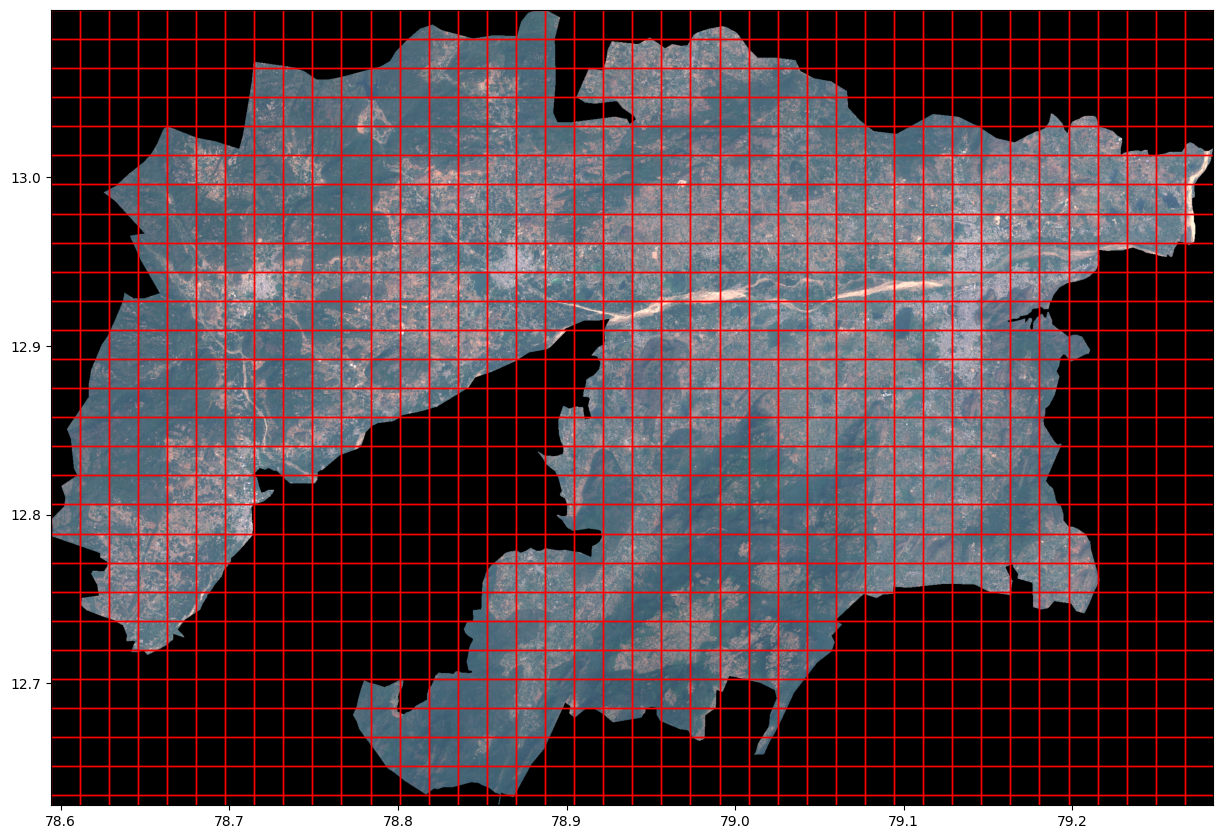

In [ ]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

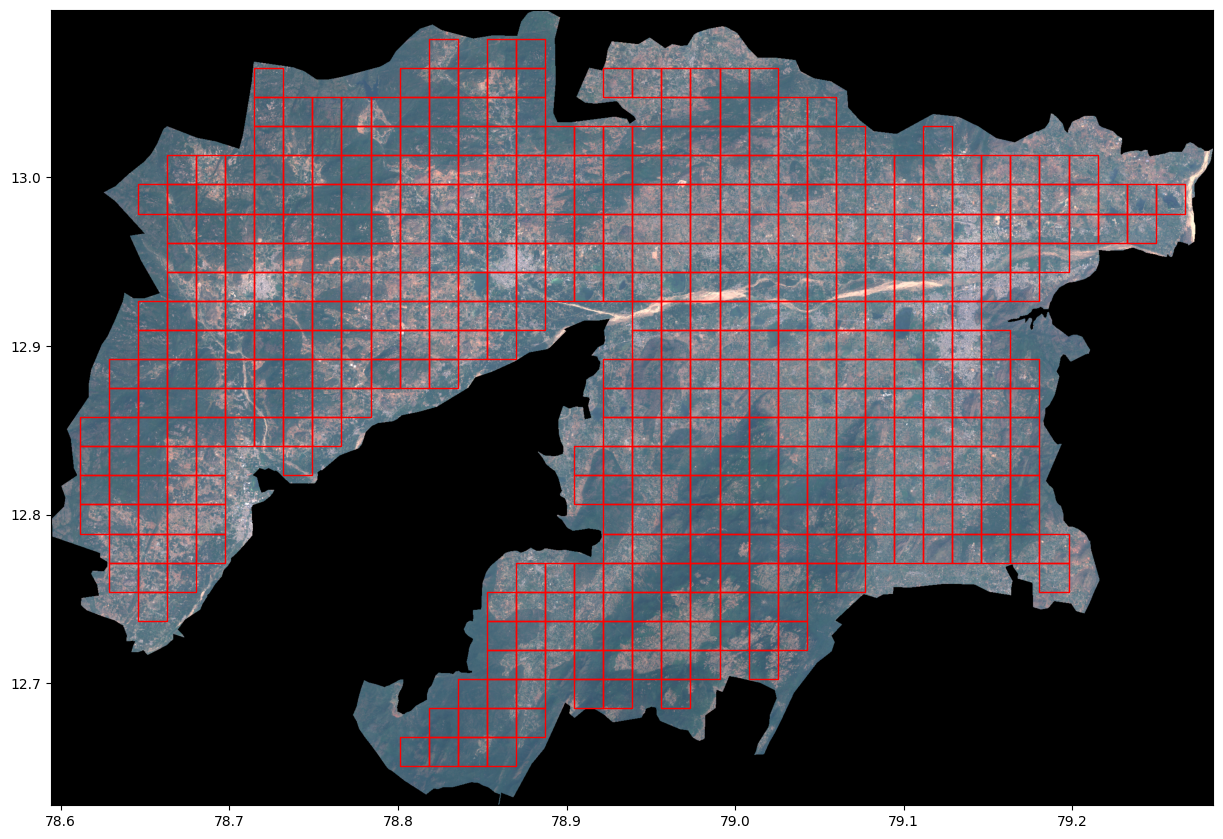

In [ ]:
import geopandas as gpd

image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, predicate='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

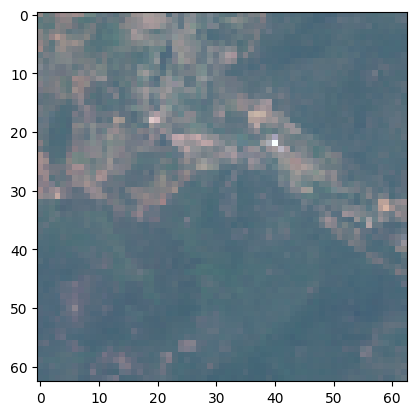

In [ ]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

In [ ]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'resnet-50-eurosat-model.pth'

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file ./drive/My Drive/lulc-project/resnet-50-eurosat-model.pth successfully loaded.


In [ ]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [ ]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        temp_tif = './drive/My Drive/lulc-project/temp.tif'
        with rasterio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

In [ ]:
# model prediction
labels = []
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Cleanup temporary files
!rm './drive/My Drive/lulc-project/temp.tif'

# Save predictions
filepath = cwd + "{}_preds.geojson".format(shape_name)
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/488 [00:00<?, ?it/s]

id                                           geometry  \
53  vellore-53  POLYGON ((78.83552 13.06483, 78.83552 13.08208...   
55  vellore-55  POLYGON ((78.87002 13.06483, 78.87002 13.08208...   
56  vellore-56  POLYGON ((78.88726 13.06483, 78.88726 13.08208...   

    index_right shapeName shapeISO                  shapeID shapeGroup  \
53          628   Vellore           76128533B89374164863010        IND   
55          628   Vellore           76128533B89374164863010        IND   
56          628   Vellore           76128533B89374164863010        IND   

   shapeType     pred  
53      ADM2  SeaLake  
55      ADM2  SeaLake  
56      ADM2  SeaLake

In [ ]:
filepath = cwd + "{}_preds.geojson".format(shape_name)
tiles = gpd.read_file(filepath)
tiles.head(3)

id  index_right shapeName shapeISO                  shapeID  \
0  vellore-53          628   Vellore           76128533B89374164863010   
1  vellore-55          628   Vellore           76128533B89374164863010   
2  vellore-56          628   Vellore           76128533B89374164863010   

  shapeGroup shapeType     pred  \
0        IND      ADM2  SeaLake   
1        IND      ADM2  SeaLake   
2        IND      ADM2  SeaLake   

                                            geometry  
0  POLYGON ((78.83552 13.06483, 78.83552 13.08208...  
1  POLYGON ((78.87002 13.06483, 78.87002 13.08208...  
2  POLYGON ((78.88726 13.06483, 78.88726 13.08208...

In [ ]:
# We map each class to a corresponding color
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

id  index_right shapeName shapeISO                  shapeID  \
0  vellore-53          628   Vellore           76128533B89374164863010   
1  vellore-55          628   Vellore           76128533B89374164863010   

  shapeGroup shapeType     pred  \
0        IND      ADM2  SeaLake   
1        IND      ADM2  SeaLake   

                                            geometry    color  
0  POLYGON ((78.83552 13.06483, 78.83552 13.08208...  #0000ff  
1  POLYGON ((78.87002 13.06483, 78.87002 13.08208...  #0000ff

In [ ]:
# Instantiate map centered on the centroid
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# Add Google Satellite basemap
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Add LULC Map with legend
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Specify the legend color
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Add GeoJSON to feature group
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map